In [1]:
from unsupervised_dac import DAC
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

filename = 'flower1.jpg'
img = plt.imread(os.path.join('images_test_unsupervised_dac', filename))
img = cv2.resize(img, dsize=(512,512), interpolation = cv2.INTER_AREA)
shape = img.shape[1:]

def define_contour_init(img):
    center = np.array(img.shape[:-1])//2
    axes = center # major, minor axes
    angle = 0
    start_angle = 0
    end_angle = 360
    color = 1
    thickness = -1

    # Draw a filled ellipse on the input image
    mask = cv2.ellipse(np.zeros(img.shape[:-1]),center,axes,angle,start_angle,end_angle,color,thickness).astype(np.uint8)
    contour = np.squeeze(cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0][0])
    return contour
contour_init = define_contour_init(img)

/home/ahabis/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/ahabis/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ahabis/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
dac = DAC(nb_points = 200,
          n_epochs = 400,
          learning_rate = 1e-1,
          clip = 1e-1,
          exponential_decay = 1.,
          thresh = 1e-5)

In [3]:
contour, energy = dac.predict(img,contour_init)

/home/ahabis/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/ahabis/3-Deep_active_contour/unsupervised_dac.py:109: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return torch.squeeze(F.conv1d(out, kernel[None, None, :], padding="same"))[


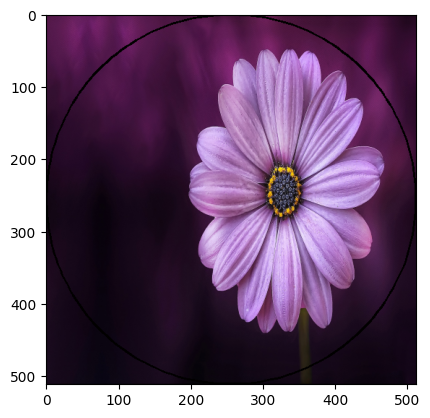

In [11]:
shape_to_display = (np.expand_dims(contour[0], 1)).astype(int)
new_img = cv2.drawContours((((img/np.max(img))*255).astype(np.uint8)).copy(),
                        [shape_to_display],
                        0,
                        color = 1,
                        thickness=2)
plt.imshow(new_img)
plt.show()

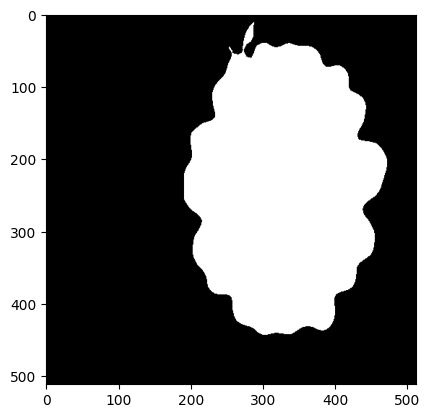

In [38]:
neros = np.zeros((512,512))
new_img = cv2.fillPoly(((neros).astype(np.uint8)).copy(),
                        [shape_to_display],
                        1)
plt.imshow(new_img, cmap ='gray')
plt.show()

In [37]:
ener = np.squeeze(energies.cpu().detach().numpy())                                                
isolines = dac.ss.cpu().detach().numpy()

for scale in range(4):
    for index, isoline in enumerate(isolines):
        
        plt.plot(np.arange(dac.n_epochs),ener[:,scale,index],label = 'isoline '+str(isoline))
    plt.title('evolution of the energies at scale: ' +str(scale+1))
    plt.xlabel('step')
    plt.ylabel('energie value')
    plt.legend()
    plt.show()

NameError: name 'energies' is not defined

In [ ]:
fig = plt.figure()

cmap = matplotlib.cm.get_cmap('seismic')

colors = [cmap(u)[:-1] for u in np.linspace(0,1,dac.n_epochs+1)]
colors = (np.array(colors)*255).astype(np.int32).tolist()



tots = []
imgs = []

for i, shape in enumerate(shape_fin[y]):

    shape_to_display = (np.expand_dims(shape, 1)).astype(int)
    
    new_img = cv2.drawContours((((img/np.max(img))*255).astype(np.uint8)).copy(),
                               [shape_to_display],
                               0,
                               color = colors[i],
                               thickness=1)
    im = plt.imshow(new_img.astype(np.uint8), animated=True)
    
    imgs.append([im])
    
ani = animation.ArtistAnimation(fig, 
                                imgs,
                                interval=50,
                                blit=False,
                                repeat_delay=1000)
plt.show()